Data source :https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

This is an attempt to check the performance of neural network on balanced predictive maintenance data.  
In the previous notebook , the performance of Gradient Boosting Classifier has shown that a f1 score of 0.76 is achieved for the minority class i.e machine failure.  
This is to check if NN can out perform the above.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
import imblearn

In [77]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate, StratifiedKFold, GridSearchCV, KFold , cross_val_score , cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score , roc_curve , precision_recall_curve, auc, f1_score

In [5]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [6]:
data = pd.read_csv("ai4i2020.csv")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [8]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [9]:
data['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [10]:
failure_pct = (data[data['Machine failure'] ==1].shape[0]/data.shape[0])*100
failure_pct

3.39

In [11]:
print("Unbalanced data set with {}% machine failures. ".format(failure_pct))

Unbalanced data set with 3.39% machine failures. 


Split data into train and test 1 and test 2.  

In [12]:
test_0 = data[data['Machine failure'] == 0].sample(frac = 0.1, random_state = 1)
test_1 = data[data['Machine failure'] == 1].sample(frac = 0.1, random_state = 1)
test_data_1 = pd.concat([test_0 , test_1])
test_data_1.shape

(1000, 14)

In [13]:
test_data_1['Machine failure'].value_counts()

0    966
1     34
Name: Machine failure, dtype: int64

In [14]:
bal_data = data[~data.index.isin(test_data_1.index.tolist())]
##
test_0 = bal_data[bal_data['Machine failure'] == 0].sample(frac = 0.1, random_state = 12)
test_1 = bal_data[bal_data['Machine failure'] == 1].sample(frac = 0.1, random_state = 12)
test_data_2 = pd.concat([test_0 , test_1])
test_data_2.shape

(900, 14)

In [15]:
test_data_2['Machine failure'].value_counts()

0    870
1     30
Name: Machine failure, dtype: int64

In [16]:
train_data = bal_data[~bal_data.index.isin(test_data_2.index.tolist())]
print(train_data.shape)

(8100, 14)


In [17]:
train_data['Type'].value_counts()

L    4885
M    2423
H     792
Name: Type, dtype: int64

In [18]:
train_data['Machine failure'].value_counts()

0    7825
1     275
Name: Machine failure, dtype: int64

In [19]:
twf = train_data['TWF'].value_counts()
twf

0    8063
1      37
Name: TWF, dtype: int64

In [20]:
hdf = train_data['HDF'].value_counts()
hdf

0    8007
1      93
Name: HDF, dtype: int64

In [21]:
pwf = train_data['PWF'].value_counts()
pwf

0    8022
1      78
Name: PWF, dtype: int64

In [22]:
osf = train_data['OSF'].value_counts()
osf

0    8023
1      77
Name: OSF, dtype: int64

In [23]:
rnf = train_data['RNF'].value_counts()
rnf

0    8084
1      16
Name: RNF, dtype: int64

In [24]:
twf[twf.index ==1] + hdf[hdf.index ==1] + pwf[pwf.index ==1] + osf[osf.index ==1] + rnf[rnf.index ==1]

1    301
dtype: int64

Combined Failure is 301 which is greater than 275 indicating that for some cases there are multiple failures that  have occured in more than one types.  

Distribution of the numeric variables.  

In [25]:
cols = train_data.columns.tolist()

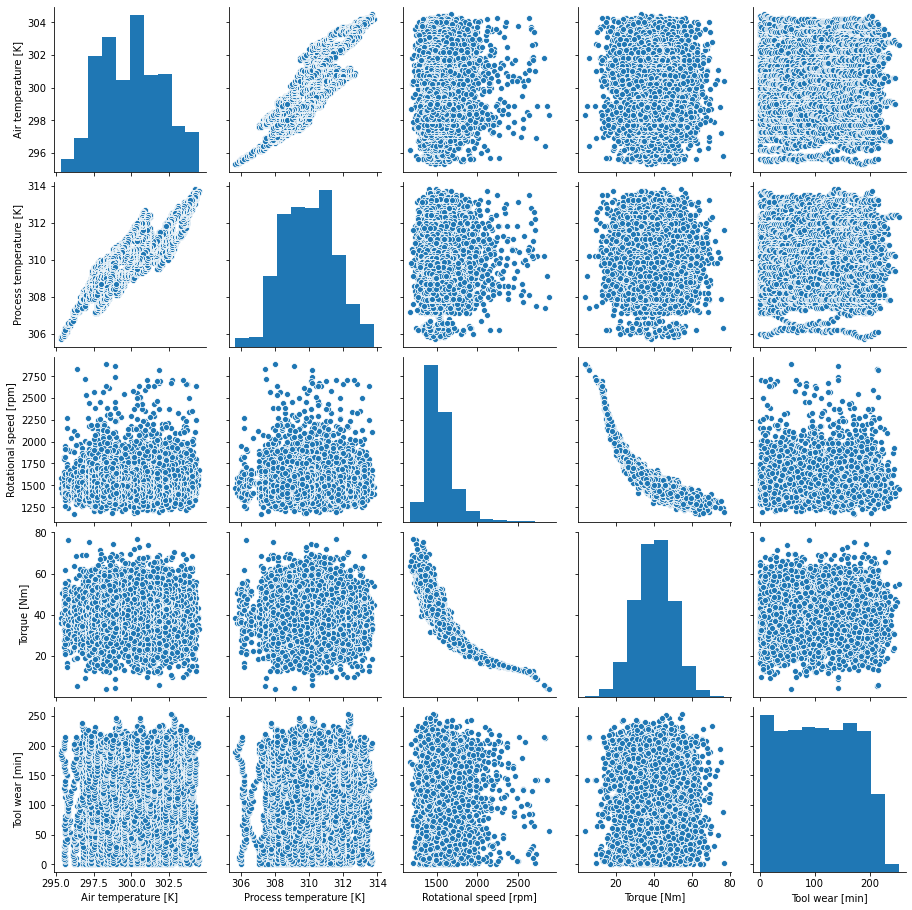

In [26]:
sns.pairplot(train_data[cols[3:8]])

Except for Rotational speed , the numeric variables have a near gaussian distribution.  
Process temparature and air temperature show linearity and positive correlation.
Torque and Rotational speed show linearity and negative correlation.  

In [27]:
train_data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [28]:
cols = train_data.columns.tolist()

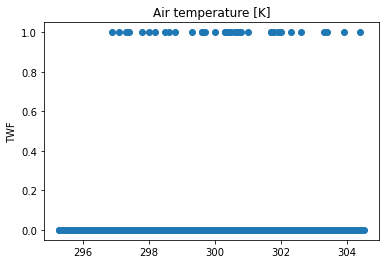

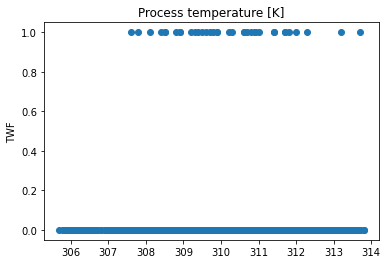

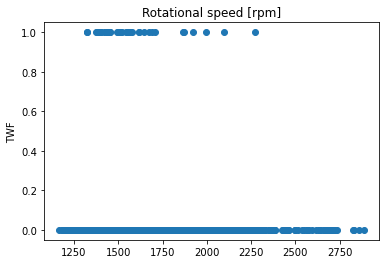

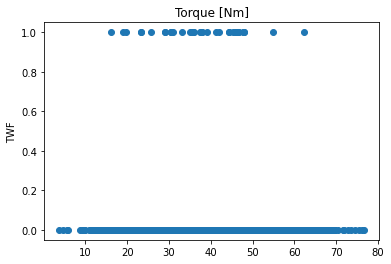

In [29]:
## Plot the failures against the predictor variables.
for i in range(3,7):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['TWF'])
    plt.title(cols[i])
    plt.ylabel('TWF')

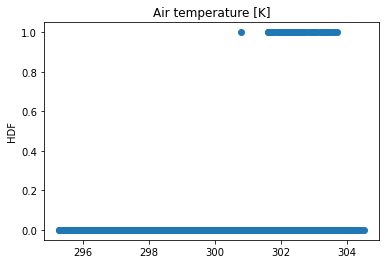

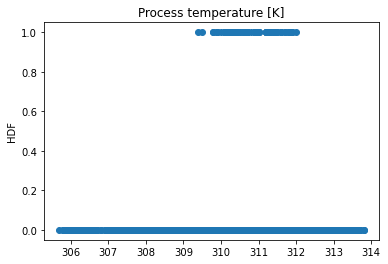

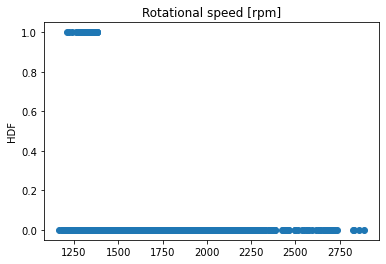

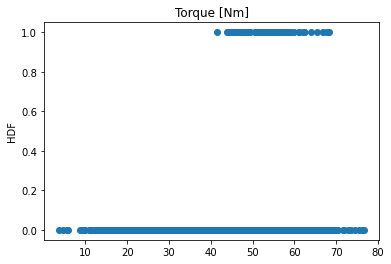

In [30]:
## Plot the failures against the predictor variables.
for i in range(3,7):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['HDF'])
    plt.title(cols[i])
    plt.ylabel('HDF')

In [32]:
predictors = train_data[cols[3:8]]
X_test = test_data_1[cols[3:8]]
y_test = test_data_1['Machine failure']
target = train_data['Machine failure']

X_train, X_validation, y_train, y_validation = train_test_split(predictors, target , stratify = target , test_size = 0.15, random_state = 12)
print("Train data size :{}".format(X_train.shape))
print("Validation data size :{}".format(X_validation.shape))
print("Test data size :{}".format(X_test.shape))

Train data size :(6885, 5)
Validation data size :(1215, 5)
Test data size :(1000, 5)


In [34]:
## Using SMOTE balance train data set 
oversample = imblearn.over_sampling.SMOTE(random_state = 3)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
##
print("Oversampled train data :{}".format(X_train_resampled.shape))
##
print("Count of classes in oversampled data :{}".format(y_train_resampled.value_counts()))
##
## Scale the input variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

Oversampled train data :(13302, 5)
Count of classes in oversampled data :1    6651
0    6651
Name: Machine failure, dtype: int64


In [35]:
y_train_resampled.value_counts()

1    6651
0    6651
Name: Machine failure, dtype: int64

In [36]:
y_validation.value_counts()

0    1174
1      41
Name: Machine failure, dtype: int64

In [37]:
y_test.value_counts()

0    966
1     34
Name: Machine failure, dtype: int64

In [38]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\n Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [40]:
## monitor the validation loss 
from tensorflow.keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
  

Epoch 1/20
208/208 [==============================] - 1s 2ms/step - loss: 0.6549 - accuracy: 0.6234 - val_loss: 0.5967 - val_accuracy: 0.7144
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5213 - accuracy: 0.8024 - val_loss: 0.4851 - val_accuracy: 0.7877
Epoch 3/20
208/208 [==============================] - 0s 2ms/step - loss: 0.4006 - accuracy: 0.8585 - val_loss: 0.4159 - val_accuracy: 0.8140
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3480 - accuracy: 0.8674 - val_loss: 0.3321 - val_accuracy: 0.8716
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3239 - accuracy: 0.8729 - val_loss: 0.3519 - val_accuracy: 0.8502
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 0.3114 - accuracy: 0.8755 - val_loss: 0.3485 - val_accuracy: 0.8593
Epoch 7/20
208/208 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.8847 - val_loss: 0.2983 - val_accuracy: 0.8831
Epoch 

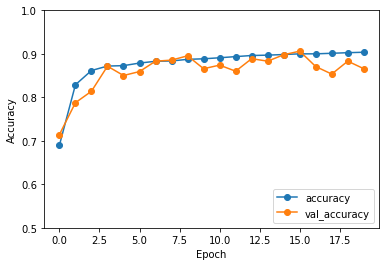

In [47]:
## With single layer , 128 neurons and binary_crossentropy loss
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optim = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set  accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [48]:
predictions = model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.where(predictions[i] >0.5 , 1,0)
    test_predicted_labels.append(pred_label[0])
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       966
           1       0.21      0.94      0.34        34

    accuracy                           0.88      1000
   macro avg       0.60      0.91      0.63      1000
weighted avg       0.97      0.88      0.91      1000


Confusion matrix :

[[843 123]
 [  2  32]]


In [124]:
## Store the results 
nn = ['128n']
pr = [0.21]
rc = [0.94]
f1score = [0.34]

Epoch 1/20
208/208 [==============================] - 1s 2ms/step - loss: 0.6625 - accuracy: 0.5779 - val_loss: 0.6434 - val_accuracy: 0.6700
Epoch 2/20
208/208 [==============================] - 0s 1ms/step - loss: 0.5753 - accuracy: 0.7483 - val_loss: 0.5799 - val_accuracy: 0.7317
Epoch 3/20
208/208 [==============================] - 0s 1ms/step - loss: 0.4680 - accuracy: 0.8360 - val_loss: 0.4736 - val_accuracy: 0.8025
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3970 - accuracy: 0.8573 - val_loss: 0.3655 - val_accuracy: 0.8658
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.8702 - val_loss: 0.3871 - val_accuracy: 0.8329
Epoch 6/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3342 - accuracy: 0.8729 - val_loss: 0.3627 - val_accuracy: 0.8519
Epoch 7/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3089 - accuracy: 0.8791 - val_loss: 0.3216 - val_accuracy: 0.8774
Epoch 

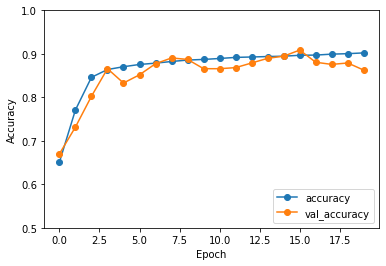

In [49]:
## With single layer , 64 neurons and binary_crossentropy loss
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation=tf.nn.relu),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optim = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [50]:
predictions = model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.where(predictions[i] >0.5 , 1,0)
    test_predicted_labels.append(pred_label[0])
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       966
           1       0.20      0.94      0.33        34

    accuracy                           0.87      1000
   macro avg       0.60      0.90      0.63      1000
weighted avg       0.97      0.87      0.91      1000


Confusion matrix :

[[839 127]
 [  2  32]]


In [125]:
## Store the results 
nn.append('64n')
pr.append(0.2)
rc.append(0.94)
f1score.append(0.33)

Epoch 1/20
208/208 [==============================] - 1s 3ms/step - loss: 0.6622 - accuracy: 0.6046 - val_loss: 0.6228 - val_accuracy: 0.6979
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7816 - val_loss: 0.5268 - val_accuracy: 0.7621
Epoch 3/20
208/208 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8415 - val_loss: 0.4392 - val_accuracy: 0.8008
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3723 - accuracy: 0.8516 - val_loss: 0.3529 - val_accuracy: 0.8617
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3488 - accuracy: 0.8631 - val_loss: 0.3834 - val_accuracy: 0.8296
Epoch 6/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3357 - accuracy: 0.8637 - val_loss: 0.3692 - val_accuracy: 0.8477
Epoch 7/20
208/208 [==============================] - 0s 2ms/step - loss: 0.3142 - accuracy: 0.8755 - val_loss: 0.3296 - val_accuracy: 0.8708
Epoch 

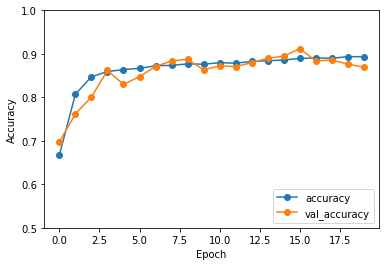

In [122]:
## With single layer , 128 neurons and binary_crossentropy loss and dropout layer 
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optim = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [123]:
predictions = model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.where(predictions[i] >0.5 , 1,0)
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       966
           1       0.21      0.94      0.34        34

    accuracy                           0.88      1000
   macro avg       0.60      0.91      0.64      1000
weighted avg       0.97      0.88      0.91      1000


Confusion matrix :

[[844 122]
 [  2  32]]


In [127]:
## Store the results 
nn.append('128n + 0.2dropout')
pr.append(0.21)
rc.append(0.94)
f1score.append(0.34)

Epoch 1/20
208/208 [==============================] - 1s 3ms/step - loss: 0.6965 - accuracy: 0.5077 - val_loss: 0.7190 - val_accuracy: 0.3967
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.5821 - val_loss: 0.6870 - val_accuracy: 0.5300
Epoch 3/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.6678 - val_loss: 0.6244 - val_accuracy: 0.6716
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5925 - accuracy: 0.7203 - val_loss: 0.5989 - val_accuracy: 0.7045
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7817 - val_loss: 0.5564 - val_accuracy: 0.7391
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 0.5053 - accuracy: 0.8057 - val_loss: 0.4605 - val_accuracy: 0.8412
Epoch 7/20
208/208 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.8346 - val_loss: 0.4376 - val_accuracy: 0.8379
Epoch 

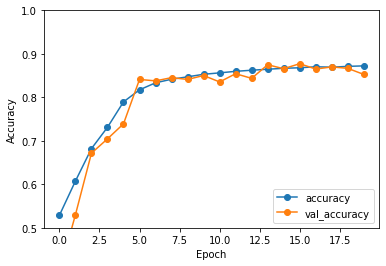

In [128]:
## With single layer , 12 neurons and binary_crossentropy loss 
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(12, activation=tf.nn.relu),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optim = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
####
predictions = model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.where(predictions[i] >0.5 , 1,0)
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


In [129]:
## Store the results 
nn.append('12nn')
pr.append(0.18)
rc.append(0.91)
f1score.append(0.3)

Epoch 1/20
208/208 [==============================] - 1s 3ms/step - loss: 0.7110 - accuracy: 0.5205 - val_loss: 0.7070 - val_accuracy: 0.4477
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.5837 - val_loss: 0.6916 - val_accuracy: 0.5374
Epoch 3/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.6438 - val_loss: 0.6483 - val_accuracy: 0.6609
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6373 - accuracy: 0.6801 - val_loss: 0.6401 - val_accuracy: 0.6675
Epoch 5/20
208/208 [==============================] - 1s 3ms/step - loss: 0.6118 - accuracy: 0.7116 - val_loss: 0.6204 - val_accuracy: 0.6881
Epoch 6/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.7260 - val_loss: 0.5536 - val_accuracy: 0.8000
Epoch 7/20
208/208 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.7480 - val_loss: 0.5360 - val_accuracy: 0.8041
Epoch 

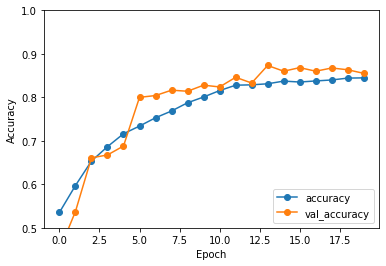

In [130]:
## With single layer , 12 neurons and binary_crossentropy loss and dropout layer 
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

optim = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set  accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
####
predictions = model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.where(predictions[i] >0.5 , 1,0)
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


In [131]:
## Store the results 
nn.append('12nn + 0.2dropout')
pr.append(0.18)
rc.append(0.91)
f1score.append(0.3)

Epoch 1/20
208/208 [==============================] - 1s 3ms/step - loss: 0.6955 - accuracy: 0.4851 - val_loss: 0.7120 - val_accuracy: 0.2864
Epoch 2/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.6181 - val_loss: 0.6940 - val_accuracy: 0.5021
Epoch 3/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6544 - accuracy: 0.6923 - val_loss: 0.6659 - val_accuracy: 0.6288
Epoch 4/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6357 - accuracy: 0.7204 - val_loss: 0.6520 - val_accuracy: 0.6486
Epoch 5/20
208/208 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.7331 - val_loss: 0.6313 - val_accuracy: 0.6716
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 0.5973 - accuracy: 0.7371 - val_loss: 0.5742 - val_accuracy: 0.7704
Epoch 7/20
208/208 [==============================] - 1s 3ms/step - loss: 0.5680 - accuracy: 0.7629 - val_loss: 0.5560 - val_accuracy: 0.7835
Epoch 

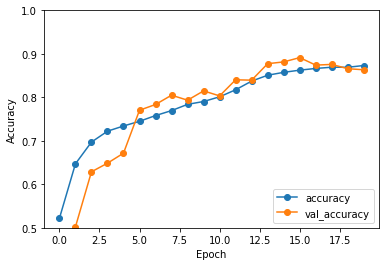

In [132]:
## With two layers  of  128 neurons and w/o callback.

    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled,y_train_resampled, epochs=20, validation_data = (X_validation_scaled,y_validation), batch_size = 64, shuffle =True)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set  accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [133]:
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       966
           1       0.19      0.91      0.31        34

    accuracy                           0.86      1000
   macro avg       0.59      0.89      0.62      1000
weighted avg       0.97      0.86      0.90      1000


Confusion matrix :

[[833 133]
 [  3  31]]


In [134]:
## Store the results 
nn.append('128n + 128nn + 0.1dropout')
pr.append(0.19)
rc.append(0.91)
f1score.append(0.31)

Epoch 1/10
208/208 [==============================] - 1s 5ms/step - loss: 0.6815 - accuracy: 0.5576 - val_loss: 299.2795 - val_accuracy: 0.0337
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.6860 - val_loss: 1033.1089 - val_accuracy: 0.0337
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.7619 - val_loss: 2490.4575 - val_accuracy: 0.0337
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.4809 - accuracy: 0.8227 - val_loss: 3984.0444 - val_accuracy: 0.0337
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.8559 - val_loss: 5349.5205 - val_accuracy: 0.0337
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8580 - val_loss: 6574.0459 - val_accuracy: 0.0337
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.8673 - val_loss: 7590.0767 - val_acc

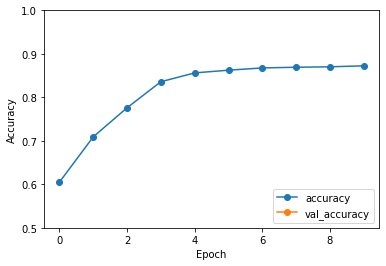

In [135]:
## With single layer , 16  neurons and class weights 
    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
    
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=10, validation_data = (X_validation,y_validation), batch_size = 64)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set  accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [136]:
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       966
           1       0.19      0.91      0.31        34

    accuracy                           0.86      1000
   macro avg       0.59      0.89      0.62      1000
weighted avg       0.97      0.86      0.90      1000


Confusion matrix :

[[831 135]
 [  3  31]]


In [137]:
## Store the results 
nn.append('16nn')
pr.append(0.19)
rc.append(0.91)
f1score.append(0.31)

In [ ]:
## VARY THE LEARNING RATE , Drop rate . Imbalanced data and neural network.

Epoch 1/10
208/208 [==============================] - 1s 3ms/step - loss: 0.6725 - accuracy: 0.5710 - val_loss: 0.6137 - val_accuracy: 0.7169
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.7789 - val_loss: 0.5345 - val_accuracy: 0.7646
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.8320 - val_loss: 0.4391 - val_accuracy: 0.8115
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8478 - val_loss: 0.3568 - val_accuracy: 0.8667
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3490 - accuracy: 0.8607 - val_loss: 0.3610 - val_accuracy: 0.8593
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3384 - accuracy: 0.8627 - val_loss: 0.3522 - val_accuracy: 0.8593
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.8716 - val_loss: 0.3324 - val_accuracy: 0.8798
Epoch 

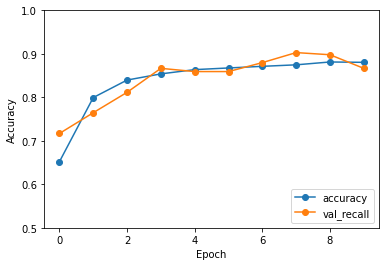

In [138]:
## with dropout 
## With single layer , 128 neurons and class weights 
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)    
#model.compile(optimizer=optim, loss= tf.keras.losses.BinaryCrossentropy(), metrics= METRICS)
model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= 'accuracy')
history = model.fit(X_train_scaled, y_train_resampled, epochs=10, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [139]:
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       966
           1       0.20      0.91      0.32        34

    accuracy                           0.87      1000
   macro avg       0.60      0.89      0.63      1000
weighted avg       0.97      0.87      0.91      1000


Confusion matrix :

[[840 126]
 [  3  31]]


In [140]:
## Store the results 
nn.append('128nn + 0.5 dropout')
pr.append(0.2)
rc.append(0.91)
f1score.append(0.32)

Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.6953 - accuracy: 0.5015 - val_loss: 0.7319 - val_accuracy: 0.0955
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5031 - val_loss: 0.7330 - val_accuracy: 0.1004
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5193 - val_loss: 0.7332 - val_accuracy: 0.1095
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5216 - val_loss: 0.7335 - val_accuracy: 0.1218
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5125 - val_loss: 0.7327 - val_accuracy: 0.1465
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5291 - val_loss: 0.7326 - val_accuracy: 0.1621
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5255 - val_loss: 0.7320 - val_accuracy: 0.1835
Epoch 

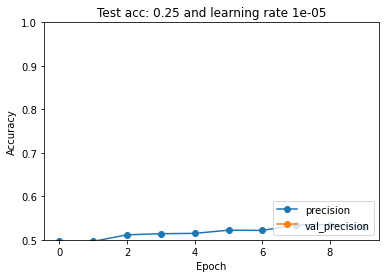

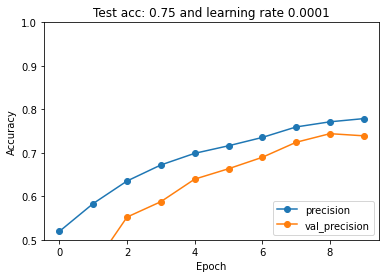

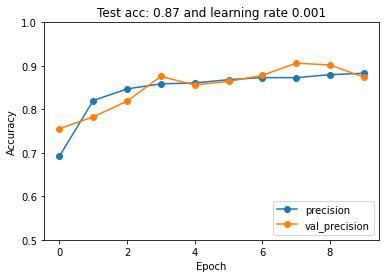

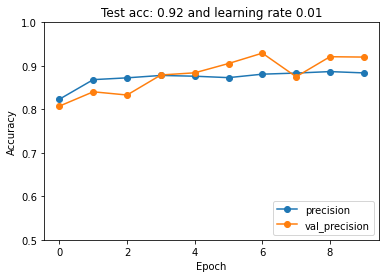

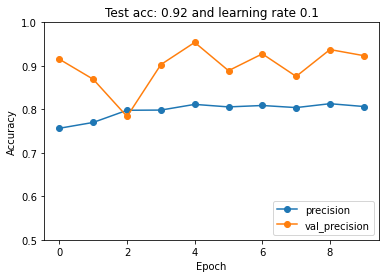

In [65]:
## Vary the learning rate 

## with dropout 
## With single layer , 128 neurons and class weights 

for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate= lr)
        

    model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])
    history = model.fit(X_train_scaled, y_train_resampled, epochs=10, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
    test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
    print("Test set accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='precision')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_precision')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("Test acc: {0} and learning rate {1}".format(np.round(test_acc,2), lr))

Learning rate of 0.01 has given the best accuracy.  

In [66]:
## Vary drop out rate 

rates = [0.1,0.2,0.3,0.4,0.5]
for rate in rates:
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
        

    model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= 'accuracy')
    history = model.fit(X_train_scaled, y_train_resampled, epochs=10, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
    test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    ## get the probability 
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    predictions = probability_model.predict(X_test_scaled)
    ## based on the max value of probability , predict the class.
    test_predicted_labels = []
    for i in range(len(predictions)):
        pred_label = np.argmax(predictions[i])
        test_predicted_labels.append(pred_label)
    ##
    print("Drop out rate  {}".format(rate))
    print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
    print("Confusion matrix :\n")
    print(confusion_matrix(y_test,test_predicted_labels))
    

Epoch 1/10
208/208 [==============================] - 1s 2ms/step - loss: 0.4745 - accuracy: 0.7642 - val_loss: 0.3288 - val_accuracy: 0.8593
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8693 - val_loss: 0.4361 - val_accuracy: 0.8082
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2714 - accuracy: 0.8888 - val_loss: 0.4096 - val_accuracy: 0.8189
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2729 - accuracy: 0.8884 - val_loss: 0.3562 - val_accuracy: 0.8535
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2597 - accuracy: 0.8974 - val_loss: 0.2013 - val_accuracy: 0.9202
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.8950 - val_loss: 0.3006 - val_accuracy: 0.8733
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9027 - val_loss: 0.2454 - val_accuracy: 0.8979
Epoch 

208/208 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8758 - val_loss: 0.3775 - val_accuracy: 0.8477
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3102 - accuracy: 0.8702 - val_loss: 0.3229 - val_accuracy: 0.8757
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3095 - accuracy: 0.8767 - val_loss: 0.2896 - val_accuracy: 0.8881
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3043 - accuracy: 0.8779 - val_loss: 0.2952 - val_accuracy: 0.8938
Epoch 7/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2894 - accuracy: 0.8881 - val_loss: 0.2120 - val_accuracy: 0.9226
Epoch 8/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2916 - accuracy: 0.8882 - val_loss: 0.3560 - val_accuracy: 0.8626
Epoch 9/10
208/208 [==============================] - 1s 2ms/step - loss: 0.2886 - accuracy: 0.8854 - val_loss: 0.2731 - val_accuracy: 0.9095
Epoch 10/10
32/32

Drop out rate of 0.1 has given the best F1 score 0.5 for class 1.  

In [68]:
## Vary neurons in the first layer

neurons = [16,32,128,256, 512]
for n in neurons:
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
        

    model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= 'accuracy')
    history = model.fit(X_train_scaled, y_train_resampled, epochs=10, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
    test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    ## get the probability 
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    predictions = probability_model.predict(X_test_scaled)
    ## based on the max value of probability , predict the class.
    test_predicted_labels = []
    for i in range(len(predictions)):
        pred_label = np.argmax(predictions[i])
        test_predicted_labels.append(pred_label)
    ##
    print("Neurons  {}".format(n))
    print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
    print("Confusion matrix :\n")
    print(confusion_matrix(y_test,test_predicted_labels))
    

Epoch 1/10
208/208 [==============================] - 1s 3ms/step - loss: 0.5808 - accuracy: 0.7015 - val_loss: 0.4271 - val_accuracy: 0.8165
Epoch 2/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3600 - accuracy: 0.8492 - val_loss: 0.3169 - val_accuracy: 0.8782
Epoch 3/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3164 - accuracy: 0.8671 - val_loss: 0.3830 - val_accuracy: 0.8412
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.3065 - accuracy: 0.8733 - val_loss: 0.3493 - val_accuracy: 0.8617
Epoch 5/10
208/208 [==============================] - 0s 1ms/step - loss: 0.3020 - accuracy: 0.8780 - val_loss: 0.2776 - val_accuracy: 0.8889
Epoch 6/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8748 - val_loss: 0.2883 - val_accuracy: 0.8872
Epoch 7/10
208/208 [==============================] - 0s 1ms/step - loss: 0.2812 - accuracy: 0.8883 - val_loss: 0.2247 - val_accuracy: 0.9078
Epoch 

208/208 [==============================] - 1s 3ms/step - loss: 0.2735 - accuracy: 0.8856 - val_loss: 0.4272 - val_accuracy: 0.8107
Epoch 4/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2813 - accuracy: 0.8830 - val_loss: 0.3575 - val_accuracy: 0.8469
Epoch 5/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.8977 - val_loss: 0.1413 - val_accuracy: 0.9506
Epoch 6/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2615 - accuracy: 0.8984 - val_loss: 0.4316 - val_accuracy: 0.8140
Epoch 7/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2450 - accuracy: 0.9046 - val_loss: 0.2802 - val_accuracy: 0.8823
Epoch 8/10
208/208 [==============================] - 1s 3ms/step - loss: 0.2454 - accuracy: 0.9066 - val_loss: 0.2736 - val_accuracy: 0.8955
Epoch 9/10
208/208 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.9067 - val_loss: 0.3638 - val_accuracy: 0.8477
Epoch 10/10
32/32

128 neurons nn has a better recall  for class 1 .  

In [105]:
## Vary epochs 

## Vary neurons in the first layer

n_epochs = [10,100,200,300]
for e in n_epochs:
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
        

    model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= 'accuracy')
    history = model.fit(X_train_scaled, y_train_resampled, epochs=e, validation_data = (X_validation_scaled,y_validation), batch_size = 64, verbose = 0)
    ##
    test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
    print("Test set accuracy :{}".format(test_acc))
    ##
    ## get the probability 
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    predictions = probability_model.predict(X_test_scaled)
    ## based on the max value of probability , predict the class.
    test_predicted_labels = []
    for i in range(len(predictions)):
        pred_label = np.argmax(predictions[i])
        test_predicted_labels.append(pred_label)
    ##
    print("Epochs  {}".format(e))
    print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
    print("Confusion matrix :\n")
    print(confusion_matrix(y_test,test_predicted_labels))
    

32/32 [==============================] - 0s 770us/step - loss: 0.1791 - accuracy: 0.9350
Test set accuracy :0.9350000023841858
Epochs  10
Classification report :
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       966
           1       0.33      0.88      0.48        34

    accuracy                           0.94      1000
   macro avg       0.66      0.91      0.72      1000
weighted avg       0.97      0.94      0.95      1000


Confusion matrix :

[[905  61]
 [  4  30]]
32/32 [==============================] - 0s 874us/step - loss: 0.1594 - accuracy: 0.9440
Test set accuracy :0.9440000057220459
Epochs  100
Classification report :
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       966
           1       0.37      0.94      0.53        34

    accuracy                           0.94      1000
   macro avg       0.68      0.94      0.75      1000
weighted avg       0.98      0.9

200 epochs has given a better f1 score for class 1 at 0.60.

32/32 [==============================] - 0s 828us/step - loss: 0.1258 - accuracy: 0.9590
Test set accuracy :0.9589999914169312


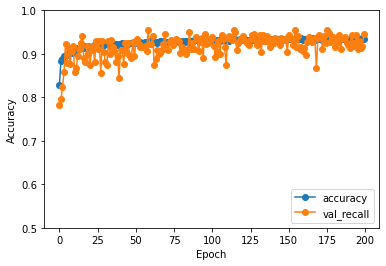

In [141]:
## NN with all the above parameters.
## Neurons = 128, drop out = 0.1 , learning rate = 0.01 ,epochs = 200

model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.01)

model.compile(optimizer=optim, loss= 'sparse_categorical_crossentropy', metrics= 'accuracy')
history = model.fit(X_train_scaled, y_train_resampled, epochs=200, validation_data = (X_validation_scaled,y_validation), batch_size = 64, verbose = 0)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [142]:
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Classification report :
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       966
           1       0.45      0.91      0.60        34

    accuracy                           0.96      1000
   macro avg       0.72      0.94      0.79      1000
weighted avg       0.98      0.96      0.97      1000


Confusion matrix :

[[928  38]
 [  3  31]]


In [143]:
## Store the results 
nn.append('128nn + 0.1 dropout + learning rate 0.01 + epochs 200')
pr.append(0.45)
rc.append(0.91)
f1score.append(0.6)

X shape (14517, 5)
y shape (14517,)
X train shape (13065, 5)
X validation shape (1452, 5)
y train shape (13065,)
y validation shape (1452,)
32/32 [==============================] - 0s 735us/step - loss: 0.0936 - accuracy: 0.9690
Test set accuracy :0.968999981880188
Classification report :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       966
           1       0.53      0.85      0.65        34

    accuracy                           0.97      1000
   macro avg       0.76      0.91      0.82      1000
weighted avg       0.98      0.97      0.97      1000


Confusion matrix :

[[940  26]
 [  5  29]]
>0.969
X train shape (13065, 5)
X validation shape (1452, 5)
y train shape (13065,)
y validation shape (1452,)
32/32 [==============================] - 0s 811us/step - loss: 0.0952 - accuracy: 0.9670
Test set accuracy :0.9670000076293945
Classification report :
              precision    recall  f1-score   support

           0       0.9

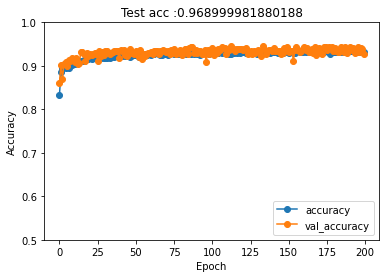

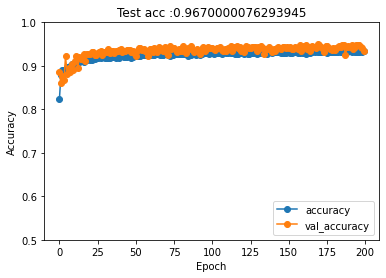

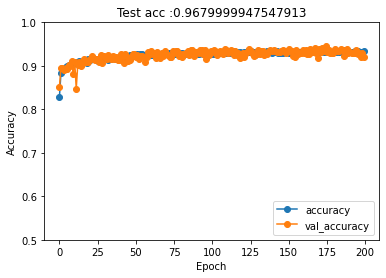

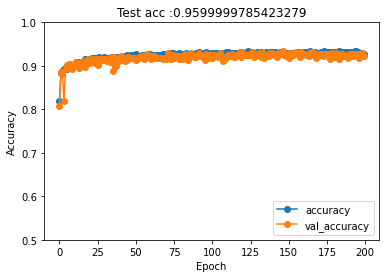

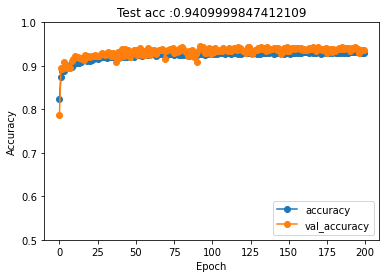

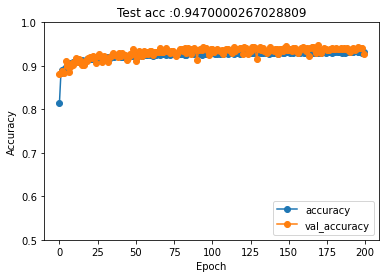

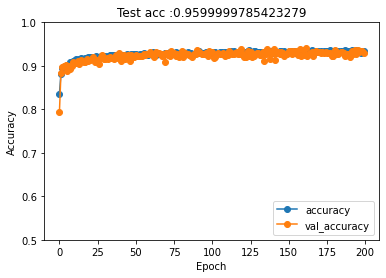

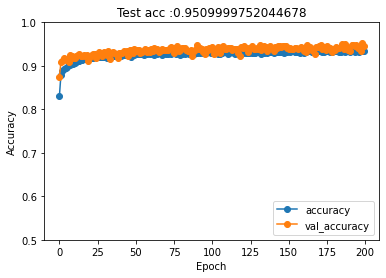

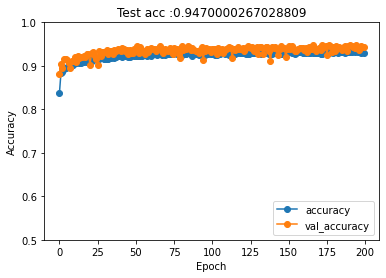

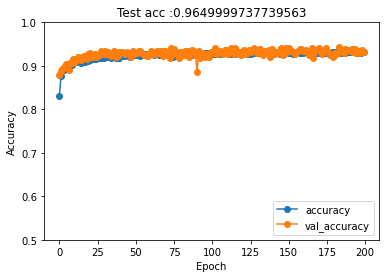

In [109]:
## Check KFold segmentation of data and test model on each segment.
## X_train_val and y_train_val contain data for training and validation 
## split them into 10 sections and train with each section and check model performance on test set  .

# enumerate splits
scores = list()
f1scores = list()


# prepare cross validation
kfold = StratifiedKFold(10, shuffle = True , random_state = 12)

X = np.concatenate((X_train_scaled, X_validation_scaled), axis = 0)
y = np.concatenate((y_train_resampled, y_validation), axis = 0)

print("X shape {}".format(X.shape))
print("y shape {}".format(y.shape))

for train_ix, validation_ix in kfold.split(X,y):
    # split data
    X_train1, X_validation1, y_train1, y_validation1 = X[train_ix], X[validation_ix], y[train_ix], y[validation_ix]
    print("X train shape {}".format(X_train1.shape))
    print("X validation shape {}".format(X_validation1.shape))
    #
    print("y train shape {}".format(y_train1.shape))
    print("y validation shape {}".format(y_validation1.shape))
    
    #print(X_train)
    
    # define model
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
   tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    # compile the model
    optim = tf.keras.optimizers.Adam(learning_rate = 0.01)
  
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train1, y_train1, epochs=200, validation_data = (X_validation1 ,y_validation1), batch_size = 64, verbose = 0)

    test_loss, test_acc = model.evaluate(X_test_scaled,y_test)

    print("Test set accuracy :{}".format(test_acc))
    
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("Test acc :" + str(test_acc))
    
    # predict test set
    ## get the probability 
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    predictions = probability_model.predict(X_test_scaled)
    ## based on the max value of probability , predict the class.
    test_predicted_labels = []
    for i in range(len(predictions)):
        pred_label = np.argmax(predictions[i])
        test_predicted_labels.append(pred_label)
    
    print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
    print("Confusion matrix :\n")
    print(confusion_matrix(y_test,test_predicted_labels))
    
    # evaluate predictions
    score = accuracy_score(y_test, test_predicted_labels)
    f1_sc = f1_score(y_test, test_predicted_labels)
    f1scores.append(f1_sc)
    print('>%.3f' % score)
    scores.append(score)
# summarize all scores
print('Mean Accuracy: %.3f Standard deviation (%.3f)' % (np.mean(scores), np.std(scores)))
print('Mean F1 score {}'.format(np.mean(f1scores)))



Cross Validation shows a mean f1score of 0.6 for class 1.    

In [82]:
## Hyper parameter tuning with Grid search CV
## 

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)
##

def create_model(learn_rate=0, units = 0 , dropout_rate = 0):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units,  activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    optim = tf.keras.optimizers.Adam(learn_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

cv_model = KerasClassifier(build_fn=create_model, epochs= 300, batch_size=64, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
##
X = np.concatenate((X_train_scaled, X_validation_scaled), axis = 0)
y = np.concatenate((y_train_resampled, y_validation), axis = 0)
##
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons = [16,32,128,256,512]
dp_rates = [0.1,0.2,0.3,0.4,0.5]

param_grid = dict(learn_rate=learn_rate, units = neurons, dropout_rate = dp_rates)
grid = GridSearchCV(estimator=cv_model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring = 'f1')
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.935412 using {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 512}
0.916244 (0.004585) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 16}
0.922702 (0.002768) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 32}
0.929111 (0.000299) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 128}
0.929653 (0.002864) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 256}
0.935185 (0.003673) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 512}
0.908528 (0.013232) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 16}
0.921827 (0.004140) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 32}
0.934837 (0.002110) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 128}
0.935275 (0.001524) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 256}
0.935412 (0.004370) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 512}
0.890989 (0.014508) with: {'dropout_rate': 0.1, 'learn_rate': 0.1, 'units': 16}
0.903172 (0.006897) wi

32/32 [==============================] - 0s 880us/step - loss: 0.1144 - accuracy: 0.9550
Test set accuracy :0.9549999833106995
Classification report :
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       966
           1       0.42      0.82      0.55        34

    accuracy                           0.95      1000
   macro avg       0.71      0.89      0.77      1000
weighted avg       0.97      0.95      0.96      1000


Confusion matrix :

[[927  39]
 [  6  28]]


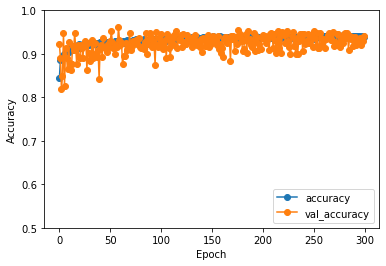

In [144]:
## NN  with the selected parameters    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
  
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=300, validation_data = (X_validation_scaled,y_validation), batch_size = 64, verbose = 0)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
###
###
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


In [145]:
## Store the results 
nn.append('512nn + 0.1 dropout + learning rate 0.01 + epochs 300')
pr.append(0.42)
rc.append(0.82)
f1score.append(0.55)

In [84]:
## Grid search CV
## 
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)
##

def create_model(learn_rate=0, units = 0 , dropout_rate = 0):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units,  activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    optim = tf.keras.optimizers.Adam(learn_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

cv_model = KerasClassifier(build_fn=create_model, epochs= 100, batch_size=64, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
##
X = np.concatenate((X_train_scaled, X_validation_scaled), axis = 0)
y = np.concatenate((y_train_resampled, y_validation), axis = 0)
##
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons = [16,32,128,256,512]
dp_rates = [0.1,0.2,0.3,0.4,0.5]


param_grid = dict(learn_rate=learn_rate, units = neurons, dropout_rate = dp_rates)
grid = GridSearchCV(estimator=cv_model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring = 'f1')
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.928540 using {'dropout_rate': 0.2, 'learn_rate': 0.01, 'units': 256}
0.900419 (0.001428) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 16}
0.906356 (0.002561) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 32}
0.916073 (0.004890) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 128}
0.918393 (0.002168) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 256}
0.924252 (0.002668) with: {'dropout_rate': 0.1, 'learn_rate': 0.001, 'units': 512}
0.915705 (0.003938) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 16}
0.920464 (0.004960) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 32}
0.925102 (0.005874) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 128}
0.917411 (0.010282) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 256}
0.921812 (0.006811) with: {'dropout_rate': 0.1, 'learn_rate': 0.01, 'units': 512}
0.670896 (0.329631) with: {'dropout_rate': 0.1, 'learn_rate': 0.1, 'units': 16}
0.902657 (0.004231) wi

32/32 [==============================] - 0s 748us/step - loss: 0.1388 - accuracy: 0.9530
Test set image accuracy :0.953000009059906
Classification report :
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       966
           1       0.42      0.97      0.58        34

    accuracy                           0.95      1000
   macro avg       0.71      0.96      0.78      1000
weighted avg       0.98      0.95      0.96      1000


Confusion matrix :

[[920  46]
 [  1  33]]


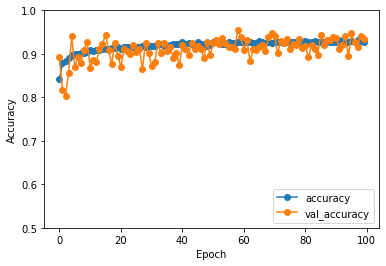

In [89]:
## NN  with the selected parameters {'dropout_rate': 0.2, 'learn_rate': 0.01, 'units': 256} and performance on test data    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(256, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
  
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=100, validation_data = (X_validation_scaled,y_validation), batch_size = 64, verbose = 0)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
###
###
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


F1 score is increased to 0.58 with the selected parameters.  

In [146]:
## Store the results 
nn.append('256nn + 0.2 dropout + learning rate 0.01 + epochs 100')
pr.append(0.42)
rc.append(0.97)
f1score.append(0.58)

In [90]:
## Grid search CV with optimizers.
## Cross Validate 

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)
##

def create_model(units = 0 , dropout_rate = 0, optimizer = 'Adam'):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units,  activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

cv_model = KerasClassifier(build_fn=create_model, epochs= 100, batch_size=64, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
##
X = np.concatenate((X_train_scaled, X_validation_scaled), axis = 0)
y = np.concatenate((y_train_resampled, y_validation), axis = 0)
##
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons = [16,32,128,256]
dp_rates = [0.1,0.2,0.3,0.4,0.5]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict( units = neurons, dropout_rate = dp_rates, optimizer = optimizer)
grid = GridSearchCV(estimator=cv_model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring = 'f1')
grid_result = grid.fit(X, y, class_weight  = {0:0.2, 1:0.8})
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.915363 using {'dropout_rate': 0.3, 'optimizer': 'Adam', 'units': 256}
0.750157 (0.011068) with: {'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 16}
0.754091 (0.005229) with: {'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 32}
0.776359 (0.003819) with: {'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 128}
0.777098 (0.002111) with: {'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 256}
0.874063 (0.011780) with: {'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 16}
0.884427 (0.006763) with: {'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 32}
0.898921 (0.009100) with: {'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 128}
0.909013 (0.003220) with: {'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 256}
0.631053 (0.000091) with: {'dropout_rate': 0.1, 'optimizer': 'Adagrad', 'units': 16}
0.631053 (0.000091) with: {'dropout_rate': 0.1, 'optimizer': 'Adagrad', 'units': 32}
0.631053 (0.000091) with: {'dropout_rate': 0.1, 'optimizer': 'Adagrad', 'units': 128

Epoch 1/100
208/208 [==============================] - 1s 3ms/step - loss: 0.6416 - accuracy: 0.6385 - val_loss: 0.5577 - val_accuracy: 0.7391
Epoch 2/100
208/208 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.8389 - val_loss: 0.3493 - val_accuracy: 0.8667
Epoch 3/100
208/208 [==============================] - 1s 3ms/step - loss: 0.3418 - accuracy: 0.8656 - val_loss: 0.3734 - val_accuracy: 0.8370
Epoch 4/100
208/208 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.8719 - val_loss: 0.2885 - val_accuracy: 0.8914
Epoch 5/100
208/208 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.8794 - val_loss: 0.3141 - val_accuracy: 0.8733
Epoch 6/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.8810 - val_loss: 0.3124 - val_accuracy: 0.8765
Epoch 7/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2758 - accuracy: 0.8925 - val_loss: 0.2643 - val_accuracy: 0.9037

Epoch 58/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9233 - val_loss: 0.2739 - val_accuracy: 0.8872
Epoch 59/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2159 - accuracy: 0.9187 - val_loss: 0.2096 - val_accuracy: 0.9185
Epoch 60/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.9157 - val_loss: 0.2515 - val_accuracy: 0.8979
Epoch 61/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.9172 - val_loss: 0.2502 - val_accuracy: 0.9004
Epoch 62/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9239 - val_loss: 0.2205 - val_accuracy: 0.9152
Epoch 63/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.9245 - val_loss: 0.2622 - val_accuracy: 0.8938
Epoch 64/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2152 - accuracy: 0.9183 - val_loss: 0.2381 - val_accuracy:

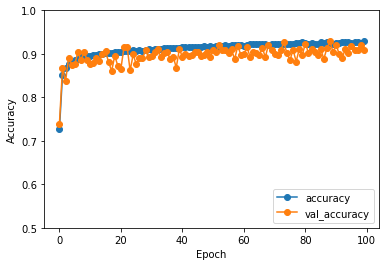

In [147]:
## NN  with the selected parameters   {'dropout_rate': 0.3, 'optimizer': 'Adam', 'units': 256} and on test data.    

model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(256, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

  
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=100, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
###
###
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


In [148]:
## Store the results 
nn.append('256nn + 0.3 dropout + learning rate 0.01 + epochs 100')
pr.append(0.31)
rc.append(0.97)
f1score.append(0.47)

In [92]:
## Grid search CV with optimizers and activation
## Cross Validate 

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)
##

def create_model(units = 0 , dropout_rate = 0, optimizer = 'Adam', activation = 'relu'):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units,  activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    # Compile model
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

cv_model = KerasClassifier(build_fn=create_model, epochs= 100, batch_size=64, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
##
X = np.concatenate((X_train_scaled, X_validation_scaled), axis = 0)
y = np.concatenate((y_train_resampled, y_validation), axis = 0)
##
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons = [16,32,128,256]
dp_rates = [0.1,0.2,0.3,0.4,0.5]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['relu', 'tanh', 'sigmoid']

param_grid = dict( units = neurons, dropout_rate = dp_rates, optimizer = optimizer, activation = activation)
grid = GridSearchCV(estimator=cv_model, param_grid=param_grid, n_jobs=-1, cv=kfold, scoring = 'f1')
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.922970 using {'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'Nadam', 'units': 256}
0.864629 (0.008922) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 16}
0.863925 (0.003623) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 32}
0.868669 (0.007730) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 128}
0.871109 (0.004419) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'SGD', 'units': 256}
0.907573 (0.004684) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 16}
0.903766 (0.003136) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 32}
0.914531 (0.007062) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 128}
0.918473 (0.002910) with: {'activation': 'relu', 'dropout_rate': 0.1, 'optimizer': 'RMSprop', 'units': 256}
0.663168 (0.075433) with: {'activation': 'relu', 'dropo

Epoch 1/100
208/208 [==============================] - 1s 3ms/step - loss: 0.6365 - accuracy: 0.6522 - val_loss: 0.5107 - val_accuracy: 0.7860
Epoch 2/100
208/208 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8429 - val_loss: 0.3449 - val_accuracy: 0.8634
Epoch 3/100
208/208 [==============================] - 0s 2ms/step - loss: 0.3342 - accuracy: 0.8699 - val_loss: 0.3777 - val_accuracy: 0.8329
Epoch 4/100
208/208 [==============================] - 0s 2ms/step - loss: 0.3093 - accuracy: 0.8777 - val_loss: 0.3121 - val_accuracy: 0.8774
Epoch 5/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2974 - accuracy: 0.8770 - val_loss: 0.2545 - val_accuracy: 0.9103
Epoch 6/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2873 - accuracy: 0.8821 - val_loss: 0.3154 - val_accuracy: 0.8716
Epoch 7/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2727 - accuracy: 0.8936 - val_loss: 0.2518 - val_accuracy: 0.9062

Epoch 58/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.9245 - val_loss: 0.2579 - val_accuracy: 0.8947
Epoch 59/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2161 - accuracy: 0.9229 - val_loss: 0.1927 - val_accuracy: 0.9226
Epoch 60/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9179 - val_loss: 0.2378 - val_accuracy: 0.9070
Epoch 61/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2173 - accuracy: 0.9200 - val_loss: 0.2218 - val_accuracy: 0.9119
Epoch 62/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.9218 - val_loss: 0.2201 - val_accuracy: 0.9136
Epoch 63/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2061 - accuracy: 0.9238 - val_loss: 0.2517 - val_accuracy: 0.8979
Epoch 64/100
208/208 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9243 - val_loss: 0.2379 - val_accuracy:

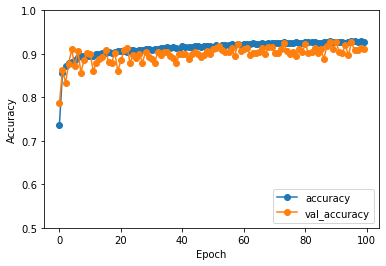

In [149]:
## NN  with the selected parameters    
model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(256, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

  
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=100, validation_data = (X_validation_scaled,y_validation), batch_size = 64)
    ##
test_loss, test_acc = model.evaluate(X_test_scaled,y_test)
print("Test set accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
###
###
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test,test_predicted_labels))


Recall is perfect at 1 but the Precision is poor. F1 score for class 1 is 0.49.   

In [150]:
## Store the results 
nn.append('256nn + 0.3 dropout + Nadam + epochs 100')
pr.append(0.3)
rc.append(0.97)
f1score.append(0.46)

In [151]:
results = {}
results['nn'] = nn
results['pr'] = pr
results['recall'] = rc
results['f1_score'] = f1score
results_df = pd.DataFrame(results)
results_df.set_index('nn', inplace = True)

In [152]:
results_df

,pr,recall,f1_score
nn,,,
128n,0.21,0.94,0.34
64n,0.20,0.94,0.33
128n + 0.2dropout,0.21,0.94,0.34
12nn,0.18,0.91,0.30
12nn + 0.2dropout,0.18,0.91,0.30
128n + 128nn + 0.1dropout,0.19,0.91,0.31
16nn,0.19,0.91,0.31
128nn + 0.5 dropout,0.20,0.91,0.32
128nn + 0.1 dropout + learning rate 0.01 + epochs 200,0.45,0.91,0.60


Based on the models above , it is seen that Neural Network has not out-performed Gradient Boosting Classifier , which has given the best f1 score of 0.75. 
However , the recall for class 1 is the best with Neural Network with a compromise on precision.  
The maximum f1_score achiveable with neural network is 0.6, where 3 out of 34 machine failures are mis-classified and 38 out of 966 non-machine failures are classified as failure.   

Check the performance of the best nn above on test data 2 .

29/29 [==============================] - 0s 757us/step - loss: 0.1417 - accuracy: 0.9433
Test set  accuracy :0.9433333277702332
Classification report :
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       870
           1       0.35      0.83      0.50        30

    accuracy                           0.94       900
   macro avg       0.67      0.89      0.73       900
weighted avg       0.97      0.94      0.95       900


Confusion matrix :

[[824  46]
 [  5  25]]


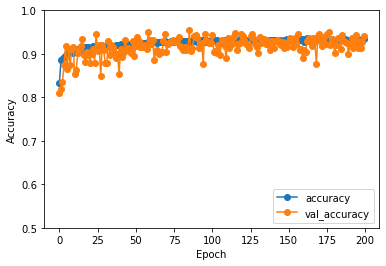

In [153]:

## Performance of the best nn above on test 2 .  


y_test2 = test_data_2['Machine failure']
X_test2_scaled = scaler.transform(test_data_2[cols[3:8]])

model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.01)
  
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_resampled, epochs=200, validation_data = (X_validation_scaled,y_validation), batch_size = 64, verbose = 0)
##

test_loss, test_acc = model.evaluate(X_test2_scaled,y_test2)
print("Test set  accuracy :{}".format(test_acc))
##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
###
###
## get the probability 
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(X_test2_scaled)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##

print("Classification report :\n{}\n".format(
     classification_report(y_test2, test_predicted_labels)))
print("Confusion matrix :\n")
print(confusion_matrix(y_test2,test_predicted_labels))